---------------------------------------------------------------------------------------------------


# 0 Introduction and Setup
### Scenario
HailMary Roofing Company, LLC is looking to expand their business into new states. Repair and replacement from hail damage is their specialty and makes up a significant portion of their business. They've hired a data analyst to identify the best US states for their new roofing teams.

### Summary
The NOAA Storm Events Database is a comprehensive dataset maintained by the National Oceanic and Atmospheric Administration (NOAA). It records severe weather events across the United States, including hail, tornadoes, floods, and other significant storms. The dataset provides detailed event information, such as date, location (state and county), event magnitude (e.g., hail size), and reported damages. With data spanning multiple years, it serves as a valuable resource for analyzing historical weather patterns and assessing the frequency and impact of severe storms.
The NOAA Storm Events Database was chosen for this analysis because it provides detailed records of hail events across the United States. Hail damage is a major driver of roofing repairs and replacements, making this dataset highly relevant to identifying expansion opportunities for the roofing company. The dataset includes state- and county-level geographic data, allowing for targeted analysis of high-risk areas. Additionally, its historical coverage enables trend analysis to identify regions with consistent hail activity, helping the company make informed business decisions about where to expand.

The American Community Survey (ACS) is a nationwide survey conducted by the U.S. Census Bureau that provides detailed demographic, social, economic, and housing data every year. The housing data from the ACS includes statistics on housing occupancy, types of housing units, home values, mortgage status, rent, and housing costs. This data is essential for understanding housing conditions and trends at the local level, such as counties and cities. This data can be used to help select potential locations that would support business expansion. Additional information about the dataset can be found here: https://www.census.gov/programs-surveys/acs/technical-documentation/code-lists.html

The counties geojson provided by https://gis-txdot.opendata.arcgis.com/datasets/texas-county-boundaries/explore.


# 1 Setup

### Import visualization libraries

In [1]:
# Import libraries
import pandas as pd          # Data manipulation
import numpy as np           # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns        # Data visualization
import os                    # File path operations
import sweetviz as sv
import folium
import json

C:\Users\nsmith\AppData\Local\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Define path to data folder
data_path = r"C:\Users\nsmith\OneDrive - Georgia Poultry Laboratory Network\CareerFoundry\02 - Data Immersion\Achievement 6\01 Data"

### Load data

In [3]:
# Generate a file path to the data
df_path = os.path.join(data_path, "cleaned_storm_data.csv")

In [4]:
# Generate a file path to the data
df_path_housing = os.path.join(data_path, "cleaned_housing_data_manual.csv")

In [5]:
# Load dataframe
df = pd.read_csv(df_path)

In [6]:
df_h = pd.read_csv(df_path_housing)

# 2 Research Questions Part 1 - Selecting a State
##### 2.1  Which types of weather events are relevant to roofing damage?
##### 2.2 Do some events cause more property damage than others?
##### 2.3 Which states experience these types of events most frequently?
##### 2.4 Which states (or counties) report the most property damage from relevant weather events?

### 2.1  Which types of weather events are relevant to roofing damage?

The current data set has been filtered to include the following categories: "Hail", "Heavy Rain", "Heavy Snow", "High Wind", "Ice Storm", "Lightning", "Strong Wind", "Thunderstorm Wind", "Winter Storm", "Winter Weather." All of these events have the potential to cause roof damage. An event count for each category is shown below.

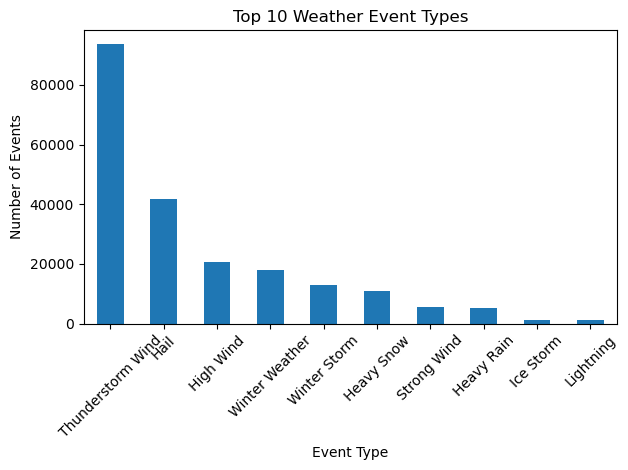

In [7]:
# plot number of events by event type
event_type_counts = df["EVENT_TYPE"].value_counts()

event_type_counts.head(10).plot(kind="bar", title="Top 10 Weather Event Types", xlabel="Event Type", ylabel="Number of Events", rot=45)
plt.tight_layout()
plt.show()

### 2.2 Do some events cause more property damage than others?

 Note that the categories showing the two highest number of events are "thunderstorm wind" and "hail." But do these categories cause the same amount of property damage?

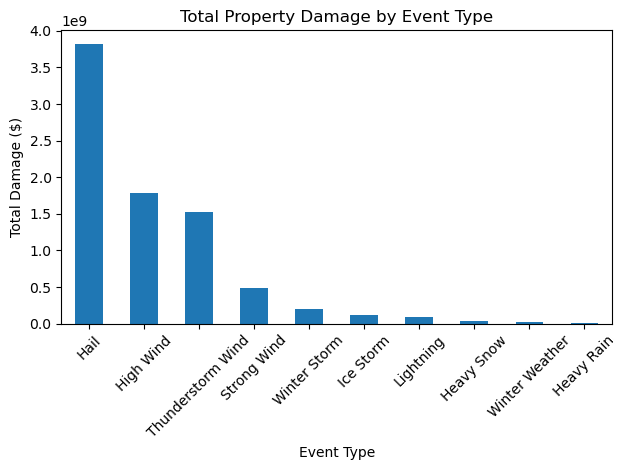

In [8]:
# Show the total property damage by event type
damage_by_event_type = df.groupby("EVENT_TYPE")["DAMAGE_PROPERTY_NUMERIC"].sum().sort_values(ascending=False)
damage_by_event_type

damage_by_event_type.head(10).plot(kind="bar", title="Total Property Damage by Event Type", xlabel="Event Type", ylabel="Total Damage ($)", rot=45)
plt.tight_layout()
plt.show()

The Hail Mary Roofing Company, LLC bases much of its current business on hail damage to roofs, so it is not a surprise to find that reported property damage is highest for the hail weather event category. The remainder of this analysis will focus on hail.

In [9]:
# Filter the dataframe to only include hail events
df_hail = df[df["EVENT_TYPE"] == "Hail"]

### 2.3 Which states experience hail events most frequently?

The Hail Mary Roofing Compnay, LLC would like to find one state where they can expand their business. Which states have the highest number of hail events?

In [10]:
# Count the total number of hail events by state
hail_state_count = df_hail["STATE"].value_counts().head(10)

# Display the hail event count by state
hail_state_count

STATE
TEXAS           6488
KANSAS          3184
OKLAHOMA        2728
NEBRASKA        2569
SOUTH DAKOTA    2132
MINNESOTA       2102
COLORADO        1968
MISSOURI        1728
IOWA            1726
ILLINOIS        1442
Name: count, dtype: int64

### 2.4 Which states (or counties) report the most property damage from relevant weather events?

Texas has nearly twice the number of hail events for the 5 year span than the second highest state. However, Texas is a big state and has large areas of land with low population density. Let's take a look at reported property damage, to confirm that there is a relationship between the high number of events and possible roof damage.

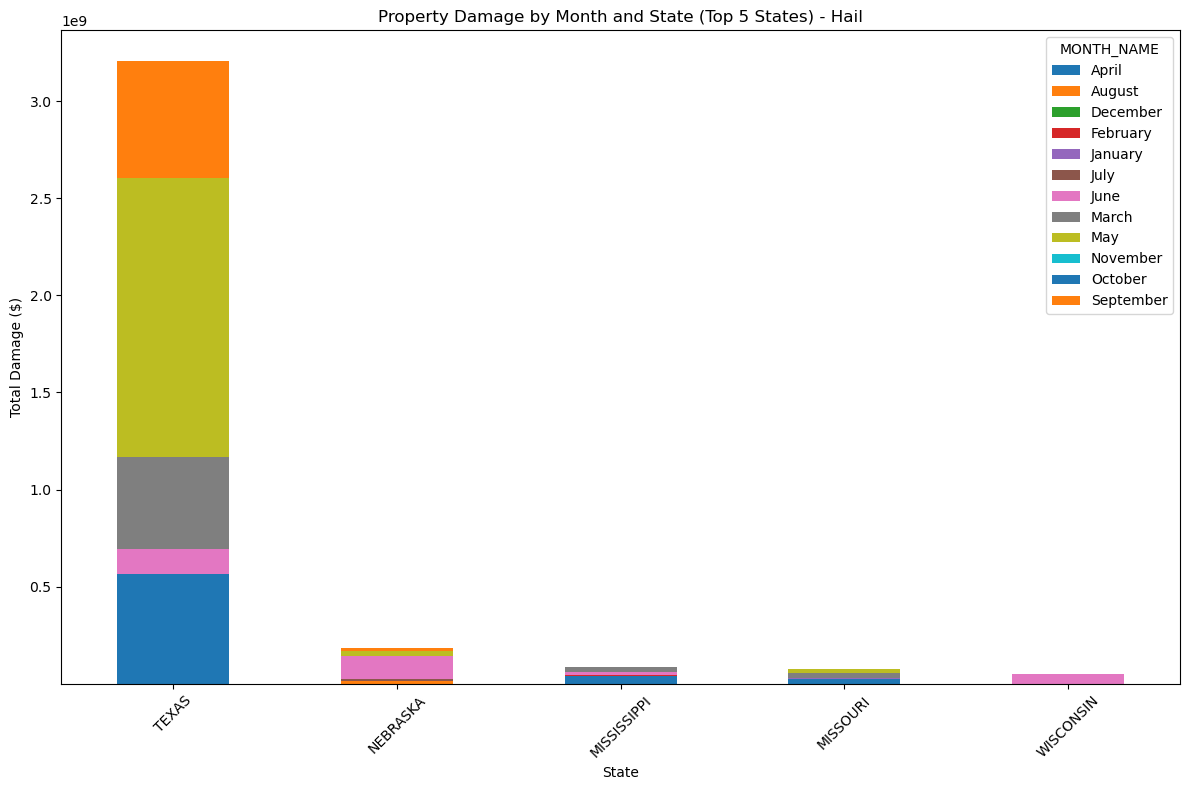

In [11]:
# Sum the damage for each state across all months (this is done by summing across the columns)
state_total_damage = df_hail.groupby("STATE")["DAMAGE_PROPERTY_NUMERIC"].sum()

# Get the top 5 states by total damage
top_5_states = state_total_damage.sort_values(ascending=False).head(5).index

# Now filter the data for the top 5 states
damage_by_state_month = df_hail[df_hail["STATE"].isin(top_5_states)]

# Group by STATE and MONTH_NAME, then sum the property damage
damage_by_state_month = damage_by_state_month.groupby(["STATE", "MONTH_NAME"])["DAMAGE_PROPERTY_NUMERIC"].sum().unstack().fillna(0)

# Plot the stacked bar chart for the top 5 states
damage_by_state_month.loc[top_5_states].plot(kind="bar", stacked=True, figsize=(12, 8), title="Property Damage by Month and State (Top 5 States) - Hail", xlabel="State", ylabel="Total Damage ($)", rot=45)

plt.tight_layout()
plt.show()

Wow! It looks like Texas would be an ideal choice for the Hail Mary Roofing Company, LLC to expand their business. For the rest of the analysis, the data will be filtered to hail storms in Texas.

In [12]:
# Filter the dataframe to only include hail events
df_hail_tx = df_hail[df_hail["STATE"] == "TEXAS"]

# 3 Explore Relationships
##### 3.1 Join housing data to the dataframe containing hail events in Texas
##### 3.2 Examine correlation

Further analysis within Texas can be supported by adding county level details regarding housing demographics, such as number of single family homes, number of owner-occupied homes, income levels, etc. The 2023 housing data for each county will be added to every hail event record in the 5 year dataset.

### 3.2 Grouping and aggregating

In order to better understand relationships, the housing categories can be grouped and aggregated.
1) Housing type: The HMRC, LLC is most interested in single family housing as this represents the largest segment of their business (as opposed to apartment buildings or housing of other types.) The fields relating to housing types will be converted to only two columns: single family and other housing.
2) The fields representing year of construction are more granular than needed for this analysis. They will be aggregated into 2 categories representing age: Newer (built after 2000) or Older (built before 2000).
3) Houses will be reclassified into small, medium, or large based on the number of bedrooms. 0-2 = small, 3-4 = medium, 5+ = large.
4) Aggregate storm events to the county level

In [13]:
# View the columns included in the dataframe
df_h.columns

Index(['County', 'HOUSING OCCUPANCY Total housing units',
       'UNITS IN STRUCTURE Total housing units',
       'UNITS IN STRUCTURE 1-unit, detached',
       'UNITS IN STRUCTURE 1-unit, attached', 'UNITS IN STRUCTURE 2 units',
       'UNITS IN STRUCTURE 3 or 4 units', 'UNITS IN STRUCTURE 5 to 9 units',
       'UNITS IN STRUCTURE 10 to 19 units',
       'UNITS IN STRUCTURE 20 or more units',
       'YEAR STRUCTURE BUILT Built 2020 or later',
       'YEAR STRUCTURE BUILT Built 2010 to 2019',
       'YEAR STRUCTURE BUILT Built 2000 to 2009',
       'YEAR STRUCTURE BUILT Built 1990 to 1999',
       'YEAR STRUCTURE BUILT Built 1980 to 1989',
       'YEAR STRUCTURE BUILT Built 1970 to 1979',
       'YEAR STRUCTURE BUILT Built 1960 to 1969',
       'YEAR STRUCTURE BUILT Built 1950 to 1959',
       'YEAR STRUCTURE BUILT Built 1940 to 1949',
       'YEAR STRUCTURE BUILT Built 1939 or earlier',
       'BEDROOMS Total housing units', 'BEDROOMS No bedroom',
       'BEDROOMS 1 bedroom', 'BEDROOMS

In [26]:
# Sorted list of unique counties
print(df_h['County'].unique())

['Angelina' 'Bastrop' 'Bell' 'Bexar' 'Bowie' 'Brazoria' 'Brazos' 'Cameron'
 'Collin' 'Comal' 'Coryell' 'Dallas' 'Denton' 'Ector' 'Ellis' 'El' 'Fort'
 'Galveston' 'Grayson' 'Gregg' 'Guadalupe' 'Harris' 'Harrison' 'Hays'
 'Henderson' 'Hidalgo' 'Hood' 'Hunt' 'Jefferson' 'Johnson' 'Kaufman'
 'Liberty' 'Lubbock' 'McLennan' 'Midland' 'Montgomery' 'Nacogdoches'
 'Nueces' 'Orange' 'Parker' 'Potter' 'Randall' 'Rockwall' 'San' 'Smith'
 'Starr' 'Tarrant' 'Taylor' 'Tom' 'Travis' 'Victoria' 'Walker' 'Webb'
 'Wichita' 'Williamson' 'Wise']


In [14]:
# Create new housing type columns
df_h["Single_Family_Homes"] = df_h["UNITS IN STRUCTURE 1-unit, detached"]
df_h["Other_Housing_Types"] = (
    df_h["UNITS IN STRUCTURE 1-unit, attached"] +
    df_h["UNITS IN STRUCTURE 2 units"] +
    df_h["UNITS IN STRUCTURE 3 or 4 units"] +
    df_h["UNITS IN STRUCTURE 5 to 9 units"] +
    df_h["UNITS IN STRUCTURE 10 to 19 units"] +
    df_h["UNITS IN STRUCTURE 20 or more units"]
)

In [15]:
# Create new age category columns
df_h["Newer_Homes"] = (
    df_h["YEAR STRUCTURE BUILT Built 2020 or later"] +
    df_h["YEAR STRUCTURE BUILT Built 2010 to 2019"] +
    df_h["YEAR STRUCTURE BUILT Built 2000 to 2009"]
)

df_h["Older_Homes"] = (
    df_h["YEAR STRUCTURE BUILT Built 1990 to 1999"] +
    df_h["YEAR STRUCTURE BUILT Built 1980 to 1989"] +
    df_h["YEAR STRUCTURE BUILT Built 1970 to 1979"] +
    df_h["YEAR STRUCTURE BUILT Built 1960 to 1969"] +
    df_h["YEAR STRUCTURE BUILT Built 1950 to 1959"] +
    df_h["YEAR STRUCTURE BUILT Built 1940 to 1949"] +
    df_h["YEAR STRUCTURE BUILT Built 1939 or earlier"]
)

In [16]:
df_h["sm_house"] = (
    df_h["BEDROOMS No bedroom"] +
    df_h["BEDROOMS 1 bedroom"] +
    df_h["BEDROOMS 2 bedrooms"]
)

df_h["med_house"] = (
    df_h["BEDROOMS 3 bedrooms"] +
    df_h["BEDROOMS 4 bedrooms"]
)

df_h["lg_house"] = df_h["BEDROOMS 5 or more bedrooms"]

In [17]:
# Drop UNITS IN STRUCTURE columns (excluding the new ones we created)
units_structure_cols = [col for col in df_h.columns if col.startswith("UNITS IN STRUCTURE")]
df_h.drop(columns=units_structure_cols, inplace=True)

# Drop YEAR STRUCTURE BUILT columns (excluding the new ones we created)
year_built_cols = [col for col in df_h.columns if col.startswith("YEAR STRUCTURE BUILT")]
df_h.drop(columns=year_built_cols, inplace=True)

# Get list of columns to drop (all BEDROOMS columns except the one with "Total housing units")
bedroom_cols_to_drop = [col for col in df_h.columns 
                        if col.startswith("BEDROOMS") and "Total housing units" not in col]
# Drop them
df_h.drop(columns=bedroom_cols_to_drop, inplace=True)


In [18]:
# Create a subset
# Create a list of columns to drop
columns_to_drop = [
    col for col in df_h.columns 
    if ("YEAR HOUSEHOLDER MOVED INTO UNIT" in col) or 
       ("VALUE" in col and "Median" not in col)
]

# Create a new subset dataframe
df_sub = df_h.drop(columns=columns_to_drop)

In [19]:
# View the columns included in the dataframe
df_sub.columns

Index(['County', 'HOUSING OCCUPANCY Total housing units',
       'BEDROOMS Total housing units', 'HOUSING TENURE Occupied housing units',
       'HOUSING TENURE Owner-occupied', 'HOUSING TENURE Renter-occupied',
       'SELECTED CHARACTERISTICS Occupied housing units',
       'VALUE (owner occupied) Median (dollars)',
       'MORTGAGE STATUS Owner-occupied units',
       'MORTGAGE STATUS Housing units with a mortgage',
       'MORTGAGE STATUS Housing units without a mortgage',
       'Single_Family_Homes', 'Other_Housing_Types', 'Newer_Homes',
       'Older_Homes', 'sm_house', 'med_house', 'lg_house'],
      dtype='object')

In [20]:
# Aggregate hail events by county
storm_agg = df_hail_tx.groupby("CZ_NAME").agg({
    "DAMAGE_PROPERTY_NUMERIC": "sum",
    "EVENT_ID": "count"  # Optional: total storm events
}).reset_index()

storm_agg.rename(columns={"EVENT_ID": "Total_Storm_Events"}, inplace=True)

In [21]:
storm_agg.head()

,CZ_NAME,DAMAGE_PROPERTY_NUMERIC,Total_Storm_Events
0,ANDERSON,23000.0,36
1,ANDREWS,10000.0,24
2,ANGELINA,0.0,10
3,ARCHER,0.0,31
4,ARMSTRONG,30000.0,10


### 3.1 Join housing data to dataframe containing hail events in Texas

In [22]:
# Convert both columns to uppercase
storm_agg['CZ_NAME'] = storm_agg['CZ_NAME'].str.upper()
df_sub['County'] = df_sub['County'].str.upper()

In [24]:
# Merge the housing data with storm data, keeping all records from the housing data
merged_df = pd.merge(df_sub, storm_agg, left_on='County', right_on='CZ_NAME', how='left')

In [25]:
# Export the merged data to a CSV file

# Define the output filename
merged_filename = "merged_data.csv"

# Join the path and filename
merged_full_output_path = os.path.join(data_path, merged_filename)

# Export the cleaned DataFrame
merged_df.to_csv(merged_full_output_path, index=False)

### 3.2 Examine correlation of variables

Create a heat map using seaborn

In [98]:
# Identify all housing-related columns (excluding 'County') and include 'DAMAGE_PROPERTY_NUMERIC'
housing_cols = [col for col in merged_df.columns if col not in ['County'] and (
    'HOUSING' in col or
    'BEDROOMS' in col or
    'TENURE' in col or
    'VALUE' in col or
    'MORTGAGE' in col or
    'CHARACTERISTICS' in col or
    'Homes' in col or
    'house' in col  # sm_house, med_house, lg_house
)]

# Add 'DAMAGE_PROPERTY_NUMERIC' to the beginning of the list
selected_cols = ['DAMAGE_PROPERTY_NUMERIC'] + housing_cols

# Create the subset
merged_df_housing = merged_df[selected_cols]


In [99]:
merged_df_housing.corr()

,DAMAGE_PROPERTY_NUMERIC,HOUSING OCCUPANCY Total housing units,BEDROOMS Total housing units,HOUSING TENURE Occupied housing units,HOUSING TENURE Owner-occupied,HOUSING TENURE Renter-occupied,SELECTED CHARACTERISTICS Occupied housing units,VALUE (owner occupied) Median (dollars),MORTGAGE STATUS Owner-occupied units,MORTGAGE STATUS Housing units with a mortgage,MORTGAGE STATUS Housing units without a mortgage,Single_Family_Homes,Newer_Homes,Older_Homes,sm_house,med_house,lg_house
DAMAGE_PROPERTY_NUMERIC,1.000000,0.286205,0.286205,0.296812,0.325708,0.259171,0.296812,0.448531,0.325708,0.375284,0.233526,0.332300,0.386352,0.215364,0.215856,0.322275,0.493069
HOUSING OCCUPANCY Total housing units,0.286205,1.000000,1.000000,0.999828,0.996253,0.995090,0.999828,0.248362,0.996253,0.987173,0.990328,0.994576,0.975920,0.990331,0.991166,0.995845,0.947836
BEDROOMS Total housing units,0.286205,1.000000,1.000000,0.999828,0.996253,0.995090,0.999828,0.248362,0.996253,0.987173,0.990328,0.994576,0.975920,0.990331,0.991166,0.995845,0.947836
HOUSING TENURE Occupied housing units,0.296812,0.999828,0.999828,1.000000,0.996610,0.995036,1.000000,0.260479,0.996610,0.989071,0.988443,0.994625,0.977998,0.988733,0.990252,0.996021,0.950807
HOUSING TENURE Owner-occupied,0.325708,0.996253,0.996253,0.996610,1.000000,0.983475,0.996610,0.280955,1.000000,0.994620,0.988600,0.998810,0.986941,0.977285,0.976554,0.999402,0.965009
HOUSING TENURE Renter-occupied,0.259171,0.995090,0.995090,0.995036,0.983475,1.000000,0.995036,0.233351,0.983475,0.973494,0.979372,0.980547,0.958316,0.993616,0.997844,0.982904,0.925010
SELECTED CHARACTERISTICS Occupied housing units,0.296812,0.999828,0.999828,1.000000,0.996610,0.995036,1.000000,0.260479,0.996610,0.989071,0.988443,0.994625,0.977998,0.988733,0.990252,0.996021,0.950807
VALUE (owner occupied) Median (dollars),0.448531,0.248362,0.248362,0.260479,0.280955,0.233351,0.260479,1.000000,0.280955,0.341510,0.154844,0.265277,0.372792,0.163024,0.203421,0.270514,0.378644
MORTGAGE STATUS Owner-occupied units,0.325708,0.996253,0.996253,0.996610,1.000000,0.983475,0.996610,0.280955,1.000000,0.994620,0.988600,0.998810,0.986941,0.977285,0.976554,0.999402,0.965009
MORTGAGE STATUS Housing units with a mortgage,0.375284,0.987173,0.987173,0.989071,0.994620,0.973494,0.989071,0.341510,0.994620,1.000000,0.967685,0.993135,0.991338,0.959636,0.961409,0.993678,0.976486


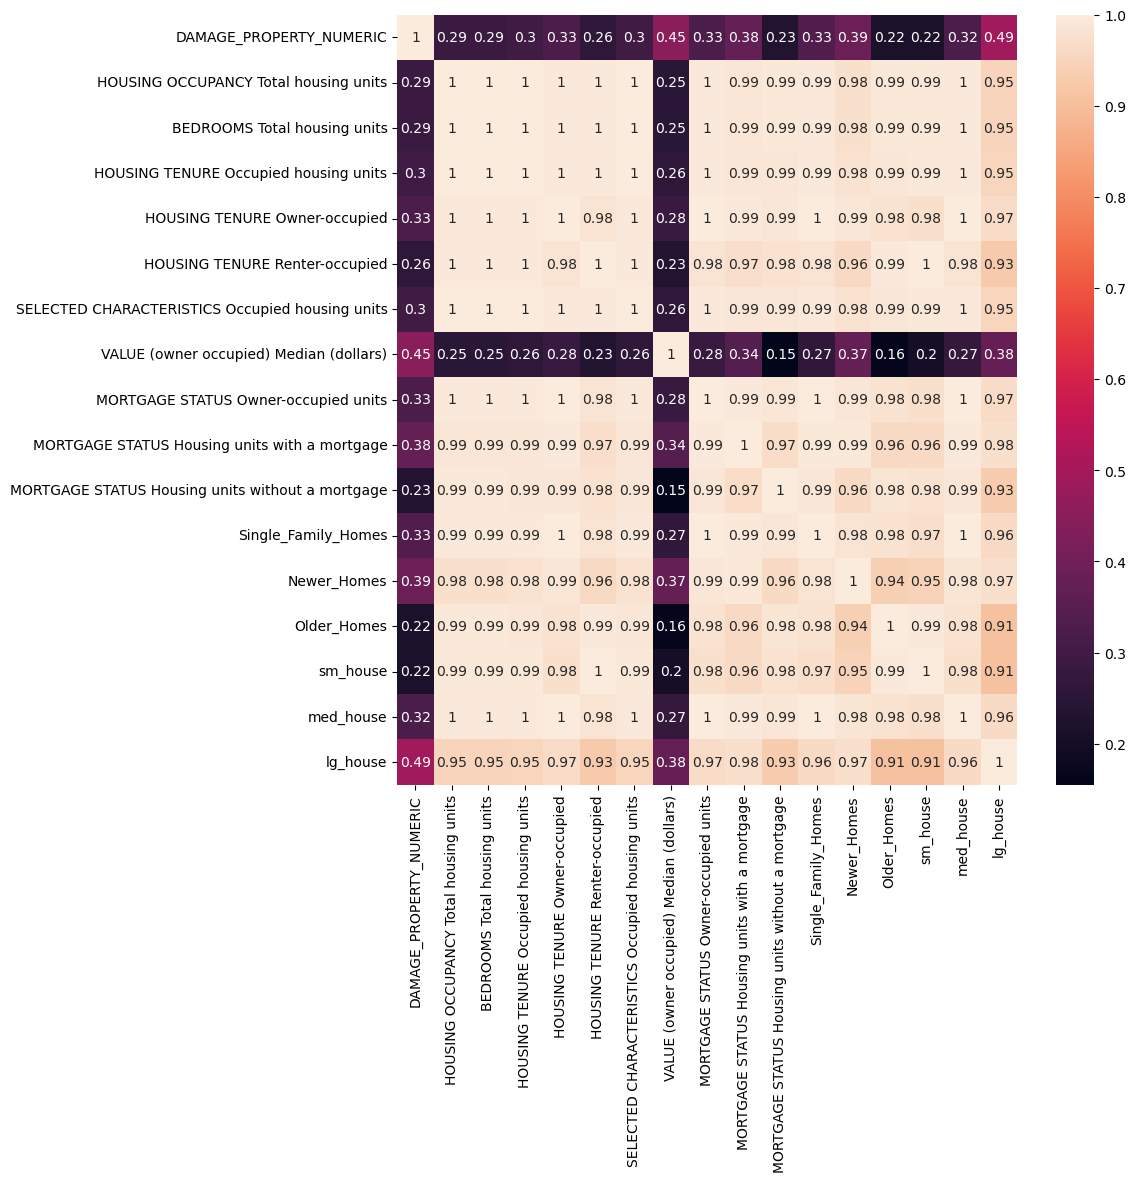

In [101]:
# Create a subplot with matplotlib
f,ax = plt.subplots(figsize=(10,10))

# Create the correlation heatmap in seaborn by applying a heatmap onto the correlation matrix and the subplots defined above.
corr = sns.heatmap(merged_df_housing.corr(), annot = True, ax = ax) # The `annot` argument allows the plot to 
#place the correlation coefficients onto the heatmap.

The heatmap above shows a strong relationship between all variables except the sum of the property damage aggregated by county and the median home value. A correlation of 1 exists in multiple cases because multiple variables represent total housing units.

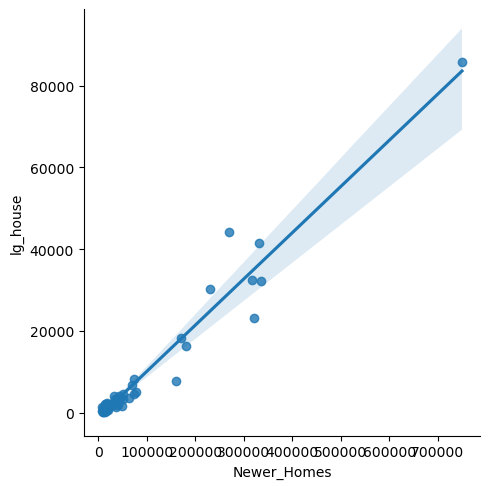

In [102]:
# Create a scatterplot for the number of newer homes and number of larger homes

sns.lmplot(x = 'Newer_Homes', y = 'lg_house', data = merged_df)

Above, a strongly positive correlation between the number of newer homes in a county and the number of larger homes in a county can be seen. This may not infer that newer homes tend to be larger, because the number of newer and larger homes has not been normalized. The relationship may reflect that when there are more homes in general, there will be both more newer homes and more larger homes.

In [103]:
# Create a pair plot 

g = sns.pairplot(merged_df)

The primary relationship to explore further will be the count of single family homes to the count of hail events within each county. For site selection, it is important to identify the counties with the highest number of hail events and the highest number of occupied single family homes.

### Categorical Plots:

<Axes: xlabel='Total_Storm_Events', ylabel='Count'>

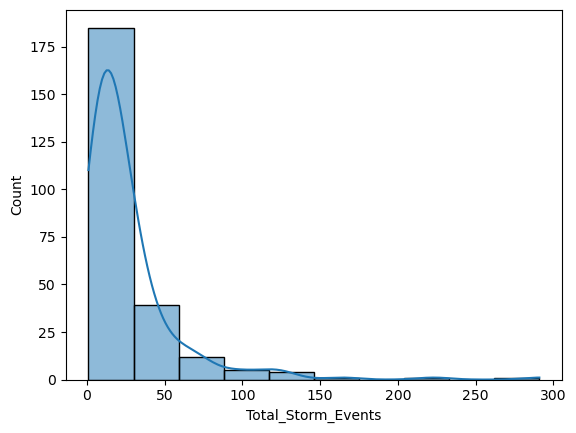

In [112]:
# Use a histogram to visualize the distribution of the total number of storm events by county
# The argument "kde" add a line that encompasses the distribution

sns.histplot(merged_df['Total_Storm_Events'], bins = 10, kde = True)

The categorical plot above shows a right-skewed distribution of the number of storm events per county. Few counties have over 150 storm events, while a high number of counties have less than 50. This indicates that the area of focus should be those few counties to the right of the graph where the number of single family dwellings is also high.

Hypotheses to test:
1) Some counties with a high number of storm events will have higher numbers of single family houses than others.
2) Some counties with a high number of storm events will have a higher median home value than others.